## STC

In [3]:
!nvidia-smi
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install rasterio
!pip install timm


Sat Apr 26 08:40:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import json
from matplotlib.path import Path
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
import torch
from torch.utils.data import DataLoader , Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.ops import nms
from torchvision import transforms
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import numpy as np
from skimage.draw import polygon
import timm
from tqdm import tqdm
from PIL import Image


In [5]:
#Needs to be mounted with local path
drive.mount('/content/drive')
from drive.MyDrive.Colab_Notebooks.INF367A.preprocessing import PreProcessing
target_dir = '/content/drive/MyDrive/Colab_Notebooks/INF367A/'
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    print(f"Created directory: {target_dir}")
else:
    print(f"Directory already exists: {target_dir}")


Mounted at /content/drive
Directory already exists: /content/drive/MyDrive/Colab_Notebooks/INF367A/


In [ ]:
print(torch.__version__)  # Ensure it's correct
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
"""
Ensure existence of SAM file. If problems with heavy model, use light.
"""
#Heavy model
sam_path= "/content/drive/MyDrive/Colab_Notebooks/INF367A/sam_vit_h_4b8939.pth"
#Light model
#sam_path = "/content/sam_vit_b_01ec64.pth"

print(f"Path: {sam_path}")
print("Exists:", os.path.exists(sam_path))
print("Is file:", os.path.isfile(sam_path))

Path: /content/drive/MyDrive/Colab_Notebooks/INF367A/sam_vit_h_4b8939.pth
Exists: True
Is file: True


In [ ]:
"""
Creating training set with labels from Train data.
"""
training_labels= np.load(target_dir + "train_images/" + "labels.npy")
print(training_labels.shape)

#check that the images are similar.
annotation_color_allocation = {
    '0' : 'black',
    '1' : 'red',
    '2' : 'blue',
    '3' : 'orange',
    '4' : 'green',
}
def visualize_images(image_array, num_images=5):
    """
    Visualizes images from a numpy array.
    Parameters:
        image_array (np.ndarray): Array of shape (N, 1024, 1024), values from 0 to 5.
        num_images (int): Number of images to show.
    """
    N = image_array.shape[0]
    num_images = min(num_images, N)
    colors = [annotation_color_allocation[str(i)] for i in range(5)]
    cmap = ListedColormap(colors)

    plt.figure(figsize=(15, 3 * num_images))

    for i in range(num_images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image_array[i], cmap=cmap, vmin=0, vmax=5,origin="lower")
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.tight_layout()
    plt.show()
#visualize_images(training_labels,training_labels.shape[0]) #Run for sanity check



(176, 1024, 1024)


In [ ]:
"""
Load annotations.
"""
with open('/content/drive/MyDrive/Colab_Notebooks/INF367A/train_annotations.json') as f:
    train_annotations= json.load(f)
print("Train annotations loaded")
print(type(train_annotations))


Train annotations loaded
<class 'dict'>


In [ ]:
"""
Creat bounding boxes, binary array of annotations and new labels.
"""
masks={}
annotation_color_converter = {
    'plantation' : 1,
    'grassland_shrubland' : 2,
    'mining' : 3,
    'logging' : 4,
}
for index in range(len(train_annotations["images"])):
  masks[f"image_{index}"]=[]
  for annotations in train_annotations["images"][index]["annotations"]:
    classification=annotation_color_converter[annotations["class"]]
    poly = annotations["segmentation"]
    xs = poly[::2]
    ys = poly[1::2]

    bounding_box = [min(xs), min(ys), max(xs), max(ys)]
    bounding_box = [int(i) for i in bounding_box]
    # Create empty mask
    height = bounding_box[3] - bounding_box[1] + 1
    width = bounding_box[2] - bounding_box[0] + 1

    rr, cc = polygon([y - bounding_box[1] for y in ys], [x - bounding_box[0] for x in xs])
    rr = np.clip(rr, 0, height - 1)
    cc = np.clip(cc, 0, width - 1)


    binary_array = np.zeros((height, width), dtype=np.uint8)
    binary_array[rr, cc] = 1
    binary_array_cropped = binary_array[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]]
    masks[f"image_{index}"].append((bounding_box, binary_array_cropped,classification))


In [ ]:
"""
Dataset definition
"""
class CroppedSegmentationDataset(Dataset):
    def __init__(self, images, annotations, image_transform=None, mask_transform=None):
        self.images = images  # shape: (176, 3, 1024, 1024)
        self.annotations = annotations  # dict: image_{i} -> list of (bbox, mask, class)
        self.image_transform = image_transform #rename to image_transform
        self.mask_transform = mask_transform

        self.data = []
        for i in range(len(images)):
            key = f"image_{i}"
            for annotation in annotations[key]:
                bbox, cropped_mask, cls = annotation
                self.data.append((i, bbox, cropped_mask, cls))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        i, bbox, cropped_mask, cls = self.data[idx]
        image = self.images[i]  # shape: (3, 1024, 1024)

        x1, y1, x2, y2 = bbox
        cropped_img = image[:, y1:y2, x1:x2]  # crop (C, H, W)

        # Convert image to channel-last for PIL: (H, W, C)
        cropped_img_np = np.transpose(cropped_img, (1, 2, 0)).astype(np.uint8)
        img_pil = Image.fromarray(cropped_img_np)

        # Ensure mask is uint8, scale to 0-255 for PIL
        mask_pil = Image.fromarray((cropped_mask * 255).astype(np.uint8))

        # Apply transforms (shared for both image and mask)
        if self.image_transform:
            img_pil = self.image_transform(img_pil)
        if self.mask_transform:
            mask_pil = self.mask_transform(mask_pil)

        mask_tensor = (mask_pil > 0).float()  # binarize mask

        return img_pil, mask_tensor, torch.tensor(cls - 1)


In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
"""
Load and create dataset of training images.
"""
training_images = np.load("/content/drive/MyDrive/Colab_Notebooks/INF367A/train_images/prepared_data.npy")
dataset = CroppedSegmentationDataset(
    images=training_images,  # shape (176, 3, 1024, 1024)
    annotations=masks,
    image_transform=image_transform,
    mask_transform=mask_transform# used for both image and mask
)

img, mask, cls = dataset[0]
print(img.shape, mask.shape, cls) #Ensure correct shapes

torch.Size([3, 224, 224]) torch.Size([1, 224, 224]) tensor(0)


In [7]:
"""
Can be skipped, due to loading trained model later
Import pre-trained model.
Ensuring correct head on model.
"""

model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Check the classifier head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_classes = 5
model.head = nn.Linear(model.head.in_features, num_classes)
print(model.head)



model.safetensors:  55%|#####4    | 189M/346M [00:00<?, ?B/s]

Linear(in_features=768, out_features=5, bias=True)


In [ ]:
"""
Training Loop.
Skip if loading later.
"""

batch_size = 32
num_epochs = 10
learning_rate = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
def train(model, dataloader, optimizer, criterion, device, num_epochs):

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for imgs, _, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)  # shape: (B, 5)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")


In [ ]:
"""
Loading of model.
Change commented lines if training a new model.
"""
#train(model, train_loader, optimizer, criterion, device, num_epochs)
#torch.save(model.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/INF367A/vit_segment_classifier.pth")
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/INF367A/vit_segment_classifier.pth"))


<All keys matched successfully>

In [ ]:
"""
Importing and defining SAM model.
"""
threshold_pixels = 1024*1024*0.002 #ensure that to small parts are avoided
print(threshold_pixels)
#Heavy model
sam_path= "/content/drive/MyDrive/Colab_Notebooks/INF367A/sam_vit_h_4b8939.pth"

print(f"Path: {sam_path}")
print("Exists:", os.path.exists(sam_path))
print("Is file:", os.path.isfile(sam_path))
sam = sam_model_registry["default"](checkpoint=sam_path)
mask_generator = SamAutomaticMaskGenerator(sam,points_per_side=32,  # 32x32 grid = 1024 prompts
    min_mask_region_area=int(threshold_pixels),  # following threshold
    pred_iou_thresh=0.88,
    box_nms_thresh=0.7,
    stability_score_thresh=0.85,
    crop_n_layers=0,
    output_mode='binary_mask')
device = "cuda" #Important step to ensure reasonable runtime
sam.to(device=device)


2097.152
Path: /content/drive/MyDrive/Colab_Notebooks/INF367A/sam_vit_h_4b8939.pth
Exists: True
Is file: True


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
total_params = sum(p.numel() for p in sam.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 641090608


(118, 1024, 1024, 3)


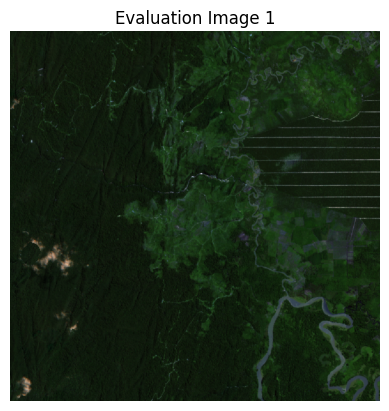

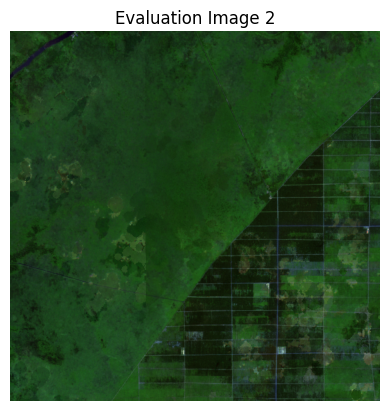

In [ ]:
"""
Ensure that evaluation images are correct.
"""
evaluation_images = np.load("/content/drive/MyDrive/Colab_Notebooks/INF367A/evaluation_images/prepared_evaluation_data.npy")
answer_file={"images":[]}
evaluation_images = evaluation_images.transpose(0, 2, 3, 1)
print(evaluation_images.shape)
num_images_to_display = 2  # Change as needed
for i in range(num_images_to_display):
    plt.figure()  # Create a new figure for each image
    plt.imshow(evaluation_images[i])  # Display the image
    plt.title(f"Evaluation Image {i + 1}")  # Set the title
    plt.axis('off')  # Hide the axes
    plt.show()


In [ ]:
"""
Using SAM to creat segments on evaluation images.
"""
print(evaluation_images[0].shape)
sam_file= {"images":[]}

for i in tqdm(range(len(evaluation_images))):
  current_results = {"filename":f"evaluation_{i}.tif","annotations":[]}
  current_masks = mask_generator.generate(evaluation_images[i])
  for preds in current_masks:
    current_results["annotations"].append(preds)
  sam_file["images"].append(current_results)






(1024, 1024, 3)


100%|██████████| 118/118 [12:16<00:00,  6.24s/it]


In [ ]:
import cv2

def binary_mask_to_polygons(binary_mask):
    """
    Convert binary masks to polygons.
    Input needs to be a numpy binary masks
    Outbut is a list of lists.
    """
    # Ensure it's uint8 (OpenCV requires this format)
    binary_mask = binary_mask.astype(np.uint8)

    # Find contours (external only)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours:
        epsilon = 1.0  # you can tweak this value
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Convert from OpenCV format to list of (x, y) tuples
        polygon = [(int(point[0][0]), int(point[0][1])) for point in approx]
        polygons.append(polygon)

    return polygons

In [ ]:
"""
Final predictions on evaluation images bounding boxes.
Goes throug every evaluation image and every segment in the images.
Saves to correct format which can be uploaded after saving to JSON.

"""
final_results={"images":[]}
model.eval()
annotation_color_reverter= {"1":"plantation",
    "2":"grassland_shrubland",
    "3":"mining",
    "4":"logging"}
for i in tqdm(range(len(evaluation_images))):
  current_results = {"file_name":f"evaluation_{i}.tif","annotations":[]}
  for j in range(len(sam_file["images"][i]["annotations"])):
    curr = sam_file["images"][i]["annotations"][j]
    x0, y0, widt, height = curr["bbox"]
    #bbox = [x0, y0, width, height]
    x1, y1, x2, y2 = x0, y0, x0 + width, y0 + height
    image_to_be_cropped = evaluation_images[i][y1:y2, x1:x2]
    if x2 - x1 <= 0 or y2 - y1 <= 0:
      continue
    # Ensure image_to_be_cropped is not empty and has valid shape
    if image_to_be_cropped.size == 0 or image_to_be_cropped.shape[0] == 0 or image_to_be_cropped.shape[1] == 0:
      print("wrong size") #never used
      continue
    # Convert to uint8 and ensure 3 channels
    image_to_be_cropped = image_to_be_cropped.astype(np.uint8)
    if image_to_be_cropped.shape[-1] != 3:
            image_to_be_cropped = np.stack([image_to_be_cropped] * 3, axis=-1)

    output= model(image_transform(Image.fromarray(image_to_be_cropped)).unsqueeze(0).to(device))
    predicted_class = output.argmax(dim=1).item()
    converted_class= annotation_color_reverter[str(predicted_class)]
    #convert to polygon
    curr_polygon =  binary_mask_to_polygons(curr["segmentation"])
    curr_polygon = curr_polygon[0]
    curr_polygon = [item for sublist in curr_polygon for item in sublist]
    current_results["annotations"].append({"class":converted_class,"segmentation":curr_polygon})

  final_results["images"].append(current_results)

100%|██████████| 118/118 [02:47<00:00,  1.42s/it]


In [ ]:
"""
Save final results as JSON
"""
with open("/content/drive/MyDrive/Colab_Notebooks/INF367A/sam_file.json", "w") as json_file:
  json.dump(final_results, json_file, indent=4)